In [45]:
%matplotlib widget
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import style
import os
import ipywidgets as widgets
from IPython.display import display, clear_output
import pandas as pd
from ipywidgets import fixed, Layout, Button, Box
import scipy.optimize as spopt 
import io
import kmc.tools
plt.style.use(['labplot', 'labplot_note'])
###################
#Preliminary setup#
###################

#getting the path file to dump txts after
try:
    with open('pathfile.txt','r') as p:
        for line in p:
            path_bash = line
except:
    path_bash = ''
#files = [i for i in os.listdir('.') if '.txt' in i]


###Buttons to be used####
#read file button
run_but = widgets.ToggleButton(
    value=False,
    description='Read File',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='check'
)

#dropdown = widgets.Dropdown(options=files, values=files[0],description='File name',disabled=False)

#file manager
dropdown = widgets.FileUpload(
    accept='.txt',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=True  # True to accept multiple files upload else False
)


#button to download the data from histogram
dump_but_hist = widgets.ToggleButton(
    value=False,
    description='Export Data',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    )
##########################

In [46]:
def filter(data,kwargs):
    #getting the restrictions to the dataset from the buttons
    thekeys = list(set([i[:-1] for i in kwargs.keys()]))
    #filtering the dataframe to leave only the dataset of interest
    data_filtered = []
    for key in thekeys:
        mats,energy,deaths,times = [kwargs[i] for i in kwargs.keys() if key in i]
        data_filtered.append(kmc.tools.filter_per_particle(data,key,deaths,mats,energy,times))    
    data_filtered =  pd.concat(data_filtered)
    return data_filtered

def filter_list(dataframes,kwargs):
    df_filtered_list = [filter(data,kwargs) for data in dataframes]
    for i in range(len(df_filtered_list)):
        try:
            df_filtered_list[i].name = dataframes[i].name
        except:
            df_filtered_list[i].name = 'Unnamed'
    return df_filtered_list

#####################################
# widgets are included through two functions:
# XXX_widget : recieves the variables from the interface's buttons and treat it to become suitable for analysis
# XXX_func   : carries out the analysis and visualization
#####################################


#### TRPL #######################
def trpl_func(dataframes,bin_num,tot_len,dump_but,legend,area_display):        
    fig,ax = plt.subplots()
    CUTS, STATS = [], []
    for dataframe in dataframes:
        fluorescence = dataframe['Time'].to_numpy(float)/1000
        hist, bins = kmc.tools.trpl(fluorescence,bin_num=10**(bin_num+9)) 
        ax.plot(bins,hist, label=dataframe.name)
        avg_lf = np.mean(fluorescence)
        STATS.append([dataframe.name,avg_lf,100*len(fluorescence)/tot_len,legend])
        cutoff = np.max(fluorescence)
        area = 0
        for h in range(len(hist)-1):
            area += hist[h]*(bins[h+1]-bins[h])
            if area >= area_display/100:
                cutoff = bins[h]
                break
        CUTS.append(cutoff)    
    stats = pd.DataFrame(STATS,columns=['File','Avg Lifetime (ns)','Sampling Space (%)','Processes'])
    display(stats.style.hide(axis='index').background_gradient().format(precision=1))
    cutoff = max(CUTS)
    ax.set_xlabel("Time (ns)")          
    ax.set_ylabel("Intensity (a.u.)")   
    ax.set_xlim([0,cutoff])
    ax.set_ylim(bottom=0)
    ax.legend()
    display(fig)
    clear_output(wait=True)
    if dump_but:
        hist_data = np.column_stack([bins, hist])
        np.savetxt(path_bash+'/trpl.txt'     , hist_data, fmt=['%f','%f'])
    
def trpl_widget(data,tot_len,**kwargs):   
    data_filtered = filter_list(data,kwargs) 
    bin_slider = widgets.FloatSlider(
    value=-9,
    max=1,
    min=-12,
    step=1,
    description='Bin:$10^x$(s)',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
    )
        
    area_slider = widgets.IntSlider(
    value=50,
    max=100,
    min=1,
    step=1,
    description='Fraction (%):',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
    )

    dump_but = widgets.ToggleButton(
        value=False,
        description='Export Data',
        disabled=False,
        button_style='success', # 'success', 'info', 'warning', 'danger' or ''
        tooltip='Description',
        icon='check'
    )

    #gettin which processes were selected to the trpl calculation
    legend = []
    for i in kwargs.keys():
        if '2' in i:
            try:
                legend.append(kwargs[i][0])
            except:
                pass
    legend = ', '.join(legend).capitalize() #capitalize(' '.join(legend))
    wid  = widgets.interactive(trpl_func,dataframes=fixed(data_filtered),bin_num = bin_slider,tot_len=fixed(tot_len),dump_but=dump_but,legend=fixed(legend),area_display=area_slider)
    box  = widgets.HBox([wid.children[0],wid.children[2],wid.children[1]])
    bbox = widgets.VBox([box,wid.children[-1]])
    display(bbox)        
    
###################################
######### histogram ###############
def hist_plot(data):
    fig, ax = plt.subplots()
    ax.set_ylabel('Distribution (%)')
    width = 0.8/len(data)
    Mortes = []
    for histogram_data in data:
        mortes = histogram_data['CausaMortis'].unique()
        Mortes.extend(mortes)
    Mortes = list(set(Mortes))    
    x = np.arange(len(Mortes))
    i = 0
    for histogram_data in data:
        nums = []
        for morte in Mortes:
            n = histogram_data[histogram_data.CausaMortis == morte].shape[0]
            nums.append(n)
        nums = np.array(nums)    
        ax.bar(x+i*width, height=100*nums/np.sum(nums),width=width,label=histogram_data.name)
        i += 1
    labels=[m.upper() for m in Mortes]    
    ax.set_xticks(x + (len(data)-1)*width/2, labels=labels)
    ax.legend(loc='best')
    fig.tight_layout()
    display(fig)
    clear_output(wait=True)

    
def hist_widget(data,tot_len,**kwargs):
    data_filtered = filter_list(data,kwargs)
    hist_plot(data_filtered)

                        
###################################
def data_widget(data,**kwargs):
    df_filtered_list = filter_list(data,kwargs)
    for dat in df_filtered_list:
        display(widgets.HTML(value = f'<p style="font-size:18px;text-align:center"><b>{dat.name}</b></p>'))
        display(dat.sort_index().reset_index(drop=True))

def spec_plot(dataframes,gran,wave):
    fig, ax = plt.subplots()
    STATS = []
    for data in dataframes:
        engs = data['Energy'].to_numpy()
        hist, bins = kmc.tools.spectrum(engs,gran)
        peak = kmc.tools.get_peak(hist,bins)
        STATS.append([data.name,peak,1239.8/peak])
        if wave:
            bins = 1239.8/bins  
        if len(bins) == 1:
            ax.vlines(bins,0, hist,label=data.name,color = next(ax._get_lines.prop_cycler)['color'])
        else:
            ax.plot(bins, hist,label=data.name)
    stats = pd.DataFrame(STATS,columns=['File','Peak (eV)','Peak (nm)'])
    display(stats.style.hide(axis='index').background_gradient().format({'Peak (eV)':'{:.2f}','Peak (nm)':'{:.0f}'}))
    ax.set_ylabel('Intensity (a.u.)')
    if wave:
        ax.set_xlabel('Wavelength (nm)')
    else:    
        ax.set_xlabel('Energy (eV)')
    ax.set_ylim(bottom=0)
    ax.legend()
    display(fig)
    clear_output(wait=True)
    
    
def spec_widget(data,tot_len,**kwargs):
    data_filtered =  filter_list(data,kwargs)

    gran_slider = widgets.FloatSlider(
    value=0.01,
    max=0.2,
    min=0.01,
    step=0.01,
    description='Bin size (eV)',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f'
    )

    wave = widgets.Checkbox(
    value=False,
    description='Wavelength (nm)',
    disabled=False,
    indent=False
)

    widgets.interact(spec_plot,dataframes=fixed(data_filtered),gran=gran_slider,wave=wave)

def diff_plot(dataframes,gran):
    fig,ax = plt.subplots(1,3,figsize=(11,4))
    fig2,ax2 = plt.subplots(figsize=(11,4))
    STATS = []
    for data in dataframes:
        dx = data['DeltaX'].to_numpy()/10
        dy = data['DeltaY'].to_numpy()/10
        dz = data['DeltaZ'].to_numpy()/10
        ld = dx*dx+dy*dy+dz*dz
        ds = np.sqrt(ld)
        ld = np.sqrt(np.mean(ld))
        mu = kmc.tools.drift(data)*1e4
        STATS.append([data.name,mu[0],mu[1],mu[2],ld])
        histx, binsx = kmc.tools.spectrum(dx,gran)
        histy, binsy = kmc.tools.spectrum(dy,gran)
        histz, binsz = kmc.tools.spectrum(dz,gran)
        hists, binss = kmc.tools.spectrum(ds,gran)

        dados = [(binsx,histx),(binsy,histy),(binsz,histz)]
        for i in range(len(dados)):
            if len(dados[i][0]) > 1:
                ax[i].plot(dados[i][0], dados[i][1],label=data.name)
            else:
                ax[i].vlines(dados[i][0],0,dados[i][1],label=data.name)
        ax2.plot(binss, hists,label=data.name)        
    stats = pd.DataFrame(STATS,columns=['File','Drift x (cm/s)','Drift y (cm/s)','Drift z (cm/s)','Diffusion Length (nm)'])
    display(stats.style.hide(axis='index').background_gradient().format({'Drift x (cm/s)':'{:.2e}','Drift y (cm/s)':'{:.2e}','Drift z (cm/s)':'{:.2e}','Diffusion Length (nm)':'{:.1f}'}))
    ax[0].set_xlabel('$\Delta x$ (nm)')
    ax[1].set_xlabel('$\Delta y$ (nm)')
    ax[2].set_xlabel('$\Delta z$ (nm)')
    for a in ax:
        a.set_ylabel('Distribution')
        a.set_ylim(bottom=0)
    
    
    ax2.set_xlabel('Displacement (nm)')
    ax2.set_ylabel('Distribution')
    ax2.set_xlim(left=0)
    ax2.set_ylim(bottom=0)
    ax2.legend(loc='best')
    display(fig)
    display(fig2)
    clear_output(wait=True)
    
def diff_widget(data,tot_len,**kwargs):
    data_filtered =  filter_list(data,kwargs)

    gran_slider2 = widgets.FloatSlider(
    value=1,
    max=5,
    min=0.1,
    step=0.5,
    description='Bin size (nm)',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f'
    )

    widgets.interact(diff_plot,dataframes=fixed(data_filtered),gran=gran_slider2)
    
#core function
def main(file_name,run_button):
    #print('the file '+ list(file_name.keys())[0] + 'was loaded!')
    if run_button: #if 'Read file' is pressed
        name = list(file_name.keys())[0]
        
        input_list = list(file_name.keys())
        dataframes = []
        for name in input_list:
            data = file_name[name]['content']
            data = io.StringIO(data.decode('utf-8'))
            data = pd.read_csv(data)
            data = data[data.Time != 'END'] #removes the end of round lines
            #Removes zeros from time column
            data.loc[(data.Time == 0),'Time'] = 1e-12
            title = name.split('.')[0]
            title = title.split('_')
            if len(title) > 1:
                title = title[1:]    
            data.name = ' '.join(title)  #labeling the dataframes
            dataframes.append(data)
            
        data = dataframes[0] #input to be used as reference
        tot_len    = np.shape(data)[0]
        species    = np.unique(np.array([item for item in data['Type'].unique() for data in dataframes]))
        max_energy = np.amax([np.amax(data['Energy']) for data in dataframes])
        min_energy = np.amin([np.amin(data['Energy']) for data in dataframes])
        max_time   = np.amax([np.amax(data['Time'].to_numpy(float)) for data in dataframes])
        min_time   = np.amin([np.amin(data['Time'].to_numpy(float)) for data in dataframes])
        ########################################    
        #defining widgets after pre load process
        #for each particle there are two sets of widgets: 
        # 1) the ones attached to the table : [energy , mats,   deaths, status] 
        # 2) the ones attached to the widget.interactive : [energy2, mats2, deaths2, status2] 
        # Comunication between them is mediated by the report_ie_change function
        
        obserb_dics, obstab, names,boxes = [], [], [], [] 
        for part in species:
            #could extend for the other dataframes. Not sure if it is worth
            data_part     = kmc.tools.filter_data_list(data,'Type',[part])
            unique_mats   = data_part['Location'].unique()
            unique_death  = data_part['CausaMortis'].unique()
            #unique_status = data_part['Status'].unique()
            wids          = kmc.tools.get_widgets_per_particle(min_energy,max_energy,unique_mats,unique_death,min_time,max_time)
            wids2         = kmc.tools.get_widgets_per_particle(min_energy,max_energy,unique_mats,unique_death,min_time,max_time)
            names.extend([part+str(i) for i in range(len(wids))])
            obserb_dics.extend(wids)
            obstab.extend(wids2)
            boxes.append(kmc.tools.make_boxes(wids2))
            
        
        kw,avatar = {}, {}
        for i in range(len(names)):
            kw[names[i]]     = obserb_dics[i]
            avatar[names[i]] = obstab[i]

        
        ###########################
        #initializing table
        output       = widgets.Output()
        tab          = widgets.Tab()
        tab.children = boxes
        #setting up the titles of the table
        for i in range(len(species)):
            tab.set_title(i,species[i].upper())
        display(tab,output)
        
        w_data = widgets.interactive(data_widget,data=fixed(dataframes),**kw)
        
        #Calling Histogram INTERACTIVE INTERFACE
        w_hist = widgets.interactive(hist_widget,data=fixed(dataframes),tot_len=fixed(tot_len),**kw)

        
        #Calling TRPL INTERACTIVE INTERFACE
        w_trpl = widgets.interactive(trpl_widget,data=fixed(dataframes),tot_len=fixed(tot_len),**kw)

        w_spec = widgets.interactive(spec_widget,data=fixed(dataframes),tot_len=fixed(tot_len),**kw)
        
        w_diff = widgets.interactive(diff_widget,data=fixed(dataframes),tot_len=fixed(tot_len),**kw)

        accordion = widgets.Accordion(children=[w_data,w_trpl,w_hist,w_spec,w_diff], selected_index=None)
        accordion.set_title(0, 'DATA')
        accordion.set_title(1, 'TIME RESOLVED PHOTOLUMINESCENCE')
        accordion.set_title(2, 'HISTOGRAM')
        accordion.set_title(3, 'SPECTRA')
        accordion.set_title(4, 'DIFFUSION')
        accordion.set_title(5, 'HEATMAP')
        display(accordion)
        
        #this function updates the atribute value upon changes in the widget. Must remain defined inside of main()
        def report_ie_change(change):#,accordion,attrib,indx):
            with output:    
                index = list(avatar.values()).index(change.owner)        
                list(kw.values())[index].value = change.new

        for wid in avatar.values():
            wid.observe(report_ie_change,names=['value'])
        
        #needed because by default widget.interactive pops up the widgets. Tuning them invisible here..
        for indx in range(len(w_trpl.children)-1):
            w_trpl.children[indx].close()
        
        
    else:
        pass 

HTML(value='<p style="font-size:24px"><b>DASHBOARD KMC</b></p>')

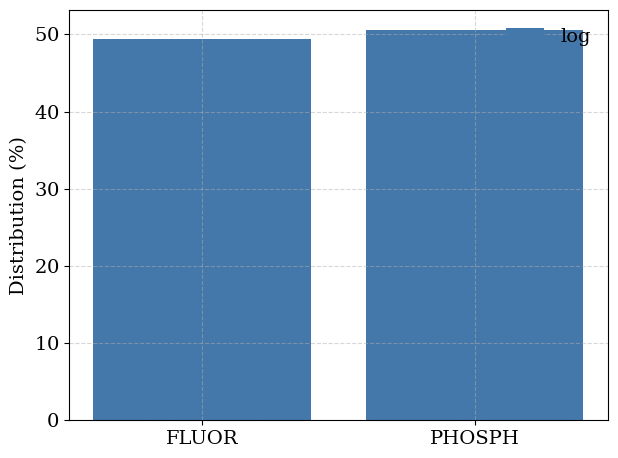

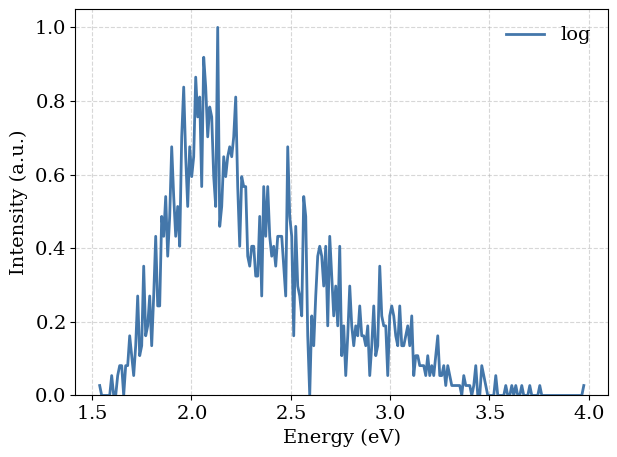

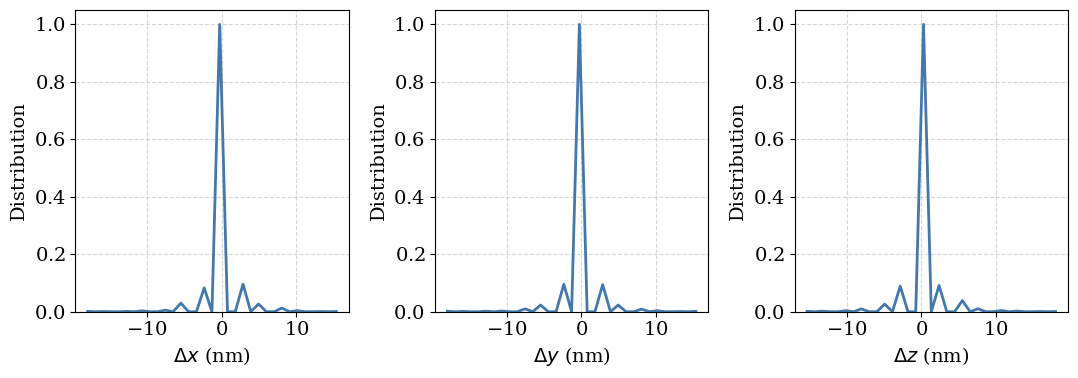

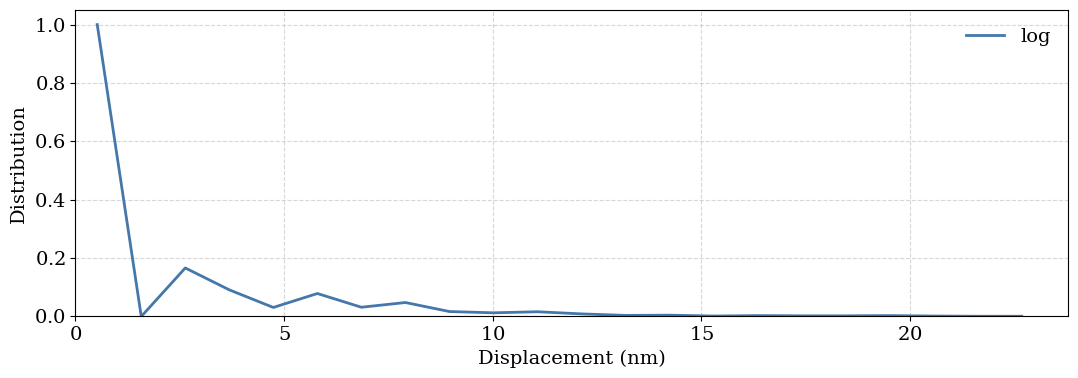

In [47]:
###################################################
#Initializing main function and displaying widgets
###################################################
display(widgets.HTML(value = r'<p style="font-size:24px"><b>DASHBOARD KMC</b></p>'))
i = widgets.interactive(main, file_name=dropdown,run_button=run_but);
h = widgets.HBox([i.children[0],i.children[1]])
v = widgets.VBox([h,i.children[2]])
display(v)